### Notebook 2: X-Ray Diffraction Plotting
This notebook shows how one might go about plotting x-ray diffraction spectra as well as doing some basic analysis of the data.

First, we do the same importing as before. However we will also be using several methods from scipy.signal.

In [1]:
import sys
import pandas as pd
sys.path.append('../lib')
#Note: When working in Windows environments, use:
#sys.path.append('..\lib')
from library import Library
from sample import Sample
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

##### Basics of Spectra Plotting
Below is the first plotting example for an xrd spectrum. To query, one first selects a position to analyze. The Pandas DataFrame that is returned may then be broken up into its substituent components, namely the incidence angle of the diffraction (xrd_angle), the intensity at that incidence (xrd_intensity), and the background subtraction, which is assessed within the API using a Gaussian smoothing. One may simply input a position to analyze and the xrd_angles, xrd_intensity, and xrd_background_subtracted are all returned to the user. Oftentimes the xrd_background_subtracted is more immediately useful,  the figures below demonstrate what the graph looks like before and after background subtraction.

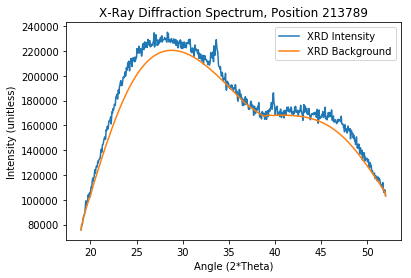

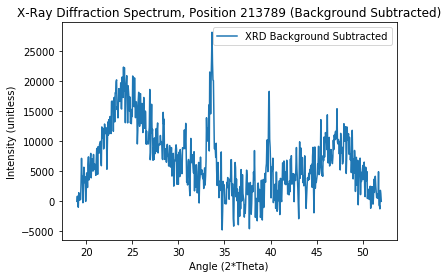

In [2]:
xrd_df = Sample(213789).spectra('xrd')
xrd_angles = list(xrd_df.xrd_angle)
xrd_intensity = list(xrd_df.xrd_intensity)
xrd_background = list(xrd_df.xrd_background)
xrd_background_subtracted = []
for i in range(0,len(xrd_background)):
    xrd_background_subtracted.append(xrd_intensity[i]-xrd_background[i])
sorted_xrd = sorted(zip(xrd_angles,xrd_intensity,xrd_background,xrd_background_subtracted),key = lambda x: x[0])
xrd_angles = [x[0] for x in sorted_xrd]
xrd_intensity = [x[1] for x in sorted_xrd]
xrd_background = [x[2] for x in sorted_xrd]
xrd_background_subtracted = [x[3] for x in sorted_xrd]
plt.figure()
plt.title('X-Ray Diffraction Spectrum, Position 213789')
plt.plot(xrd_angles,xrd_intensity,label='XRD Intensity')
plt.plot(xrd_angles,xrd_background,label='XRD Background')
plt.legend()
plt.xlabel('Angle (2*Theta)')
plt.ylabel('Intensity (unitless)')
plt.show()

plt.figure()
plt.title('X-Ray Diffraction Spectrum, Position 213789 (Background Subtracted)')
plt.plot(xrd_angles,xrd_background_subtracted,label='XRD Background Subtracted')
plt.legend()
plt.xlabel('Angle (2*Theta)')
plt.ylabel('Intensity (unitless)')
plt.show()


Suppose one wishes to algorithmically identify the peaks in an x-ray diffraction spectrum. There are many ways to do this, however the most basic way is to use a smoothing technique then apply Python's scipy.signal package, specifically the function find_peaks_cwt. This function takes a Mexican Hat Wavelet Transform to determine where the peak positions should be. One may tweak how sensitive the peak detection is based on the value of peak_detection_sensitivity. For best results, vary between 20 and 100 for the majority of samples.

/Users/mschwart/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


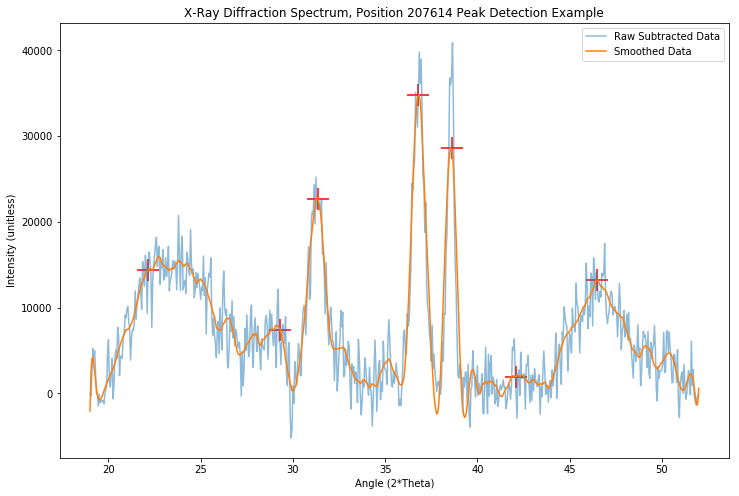

In [3]:
sample = 207614
peak_detection_sensitivity = 50

xrd_df = Sample(sample).spectra('xrd')
xrd_angles = list(xrd_df.xrd_angle)
xrd_intensity = list(xrd_df.xrd_intensity)
xrd_background = list(xrd_df.xrd_background)
xrd_background_subtracted = []
for i in range(0,len(xrd_background)):
    xrd_background_subtracted.append(xrd_intensity[i]-xrd_background[i])
sorted_xrd = sorted(zip(xrd_angles,xrd_intensity,xrd_background,xrd_background_subtracted),key = lambda x: x[0])
xrd_angles = [x[0] for x in sorted_xrd]
xrd_intensity = [x[1] for x in sorted_xrd]
xrd_background = [x[2] for x in sorted_xrd]
xrd_background_subtracted = [x[3] for x in sorted_xrd]

xrd_background_subtracted_filtered = scipy.signal.savgol_filter(xrd_background_subtracted,75,10)
plt.figure(figsize = (12,8))
plt.plot(xrd_angles,xrd_background_subtracted,label = 'Raw Subtracted Data',alpha = 0.5)
plt.plot(xrd_angles,xrd_background_subtracted_filtered,label = 'Smoothed Data')

peak_locs = scipy.signal.find_peaks_cwt(xrd_background_subtracted_filtered,np.arange(1,peak_detection_sensitivity))
for i in peak_locs:
    plt.scatter(xrd_angles[i],xrd_background_subtracted_filtered[i],marker='+',s=500,c='r')
plt.xlabel('Angle (2*Theta)')
plt.ylabel('Intensity (unitless)')
plt.legend()
plt.title('X-Ray Diffraction Spectrum, Position '+str(sample)+' Peak Detection Example')
plt.show()

The nature of peak detection, particularly for data that tends to be noisy, tends to be more subjective. What do the scientists consider to be the minimal impulse to constitute a "peak"? What about broad peaks versus narrow peaks? What about peaks with shoulders? Should they count as two peaks or as one?

The HTEM-API has its own technique to determine the number of peaks within an x-ray diffraction spectrum, which may be queried if one doesn't wish to implement their own version of peak detection. It is important to keep in mind that the results of this peak count in the API are subjective and cannot represent all samples with an equal amount of accuracy.

In [4]:
print 'Number of peaks: '+str(int(Sample(sample).properties()['peak_count']))

Number of peaks: 3


Perhaps three peaks is deemed by the researcher to be the appropriate number of peaks for this sample, but perhaps not. There are three obvious peaks in the figure above, but what about the wider peaks to the right and left? Are they to be included? These questions have no good answers, but the reader is encouraged to play with the pre-sets on the functions and come to their own conclusions.